In [10]:
# Imports
import numpy as np
import scipy as sp
# for integration and interpolation
from scipy.integrate import quad
from scipy.interpolate import interp1d
# for parrallelism
from multiprocessing import Pool
# for plotting
import matplotlib.pyplot as plt


In [11]:
from constants_module import c, hbar_GeV, me, k, h
import b_loss as b

In [12]:
''' conversions '''
#d_cyg_ref = 1.5e+3           # reference distance of the Cygnus-X region, in [pc]
conv_pc_cm = 3.086e+18       # conversion factor from [pc] to [cm]
conv_cm_pc = 3.24e-19        # conversion factor from [cm] to [pc]
conv_s_yr = 3.171e-8         # conversion factor from [sec] to [yr]
conv_yr_sec = 3.154e+7       # conversion factor from [yr] to [sec]
conv_rad_degree = 57.2958    # conversion factor from [rad] to [deg]
c = 2.998e+10                # speed of light, in [cm/s]

In [19]:
class Params:
    """
    Holds all tunable parameters for the halo model.
    """
    def __init__(self):
        # injection spectrum
        self.alpha = 2.0          # power-law index
        self.Ecut = 1e6           # cutoff energy (GeV)

        # diffusion parameters
        self.rh = 30              # transition radius [pc]
        self.D0 = 1e26            # cm^2/s (inner zone)
        self.Dism = 4e28          # cm^2/s (outer zone)
        self.del_exponent = 1/3   # spectral index of diffusion coefficient

        # luminosity parameters
        self.tau0 = 12 * conv_yr_sec
        self.Edot = 3.8e34        # erg/s (for Monogem)
        self.tobs = 110e3 * conv_yr_sec  # observation time

        # location and distance perameters
        self.rs = 1             #galactic location of source

        # integration resolution
        self.n_points = 8

# Getting Diffusion Length to Work

In [35]:
def B_anti(Ex, Emin=me):    
    '''
    Computes the antiderivative of 1/btot at a given energy to then later
    solve for E0 (the intial electron energy) as a function of Ee and t.
    Utilizes logspace to get the integral to work out properly.

    - perams - 
    Ex: some electron energy value to evaluate at
    Emin: minimum value for the integral, set to 0.1 GeV ( for now )

    - returns - 
    the antiderivative of 1/btot evaluated at Ex
    '''
    E_test = np.logspace(np.log10(me), np.log10(Ex), 50)

    def integrand_B(Ex):
        return 1 / b.b_tot(Ex)
    
    # Old one with points = E_test
    result, error = quad(integrand_B, Emin, Ex, points = E_test, 
                        epsabs=1e-12, epsrel=1e-10, limit = 1000)
    
    # result, error = quad(integrand_B, Emin, Ex,
    #                     epsabs=1e-12, epsrel=1e-10, limit = 1000)
    
    return result

def spline_to_E0s(Emin = me, Emax = 1e40):
    n_points = 10000

    Es = np.logspace(np.log10(Emin), np.log10(Emax), n_points)

    Bs_at_Es = []
    for i in range(n_points):
        Bs_at_Es.append(B_anti(Es[i]))

    inv_spline = interp1d(Bs_at_Es, Es, bounds_error=False, fill_value='extrapolate')

    return inv_spline

''' global variable '''
# spline for interpolating E0
E0_spline = spline_to_E0s()

def E0_val(Ee, tau):
    '''
    Computes the inital photon energy as a function of final
    photon energy and time difference between observation and 
    injection(tstar). Utilizes a inverse function spline to find
    the E0 that solves the necessary equation for a given Ee and
    tau.

    - perams -
    Ee: final photon energy
    tau: tobs - tinj (Defined in the hooper paper)

    - returns - 
    value of E0 at given Ee and tau
    maximum value of Ee for wich the function is defined, above that 
    there isn't any well defined values
    '''
    value = B_anti(Ee) + tau
    E0 = E0_spline(value)
    return E0

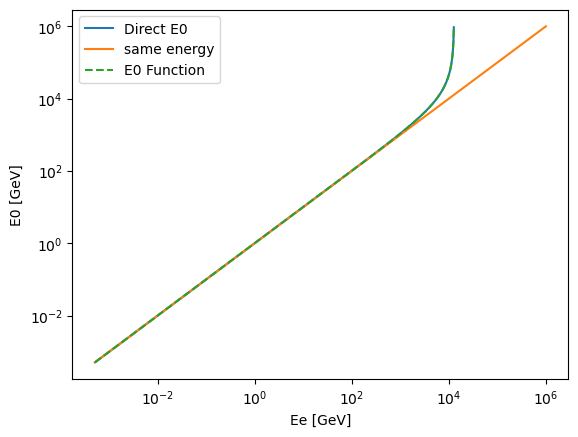

In [38]:
def plot_E0s():
    points = 1000
    Ees = np.logspace(np.log10(me), np.log10(1e6), points)
    tau = (110e3)*conv_yr_sec

    vals = []
    vals_2 = []
    for i in range(points):
        vals.append(B_anti(Ees[i]) + tau)
        vals_2.append(E0_val(Ees[i], tau))

    plt.loglog(Ees, E0_spline(vals), label = "Direct E0")
    plt.loglog(Ees, Ees, label = "same energy")
    plt.loglog(Ees, vals_2, label = "E0 Function", linestyle = "dashed")
    plt.legend()
    plt.xlabel("Ee [GeV]")
    plt.ylabel("E0 [GeV]")
    plt.show()

plot_E0s()

In [52]:
def diffusion_hoop(Ee, r):
    ''' 
    Diffusion model from the hooper paper, uses a two zone diffusion model
    with a factor rh that describes where the model changes from one zone
    to the next. Spherical diffusion is required by the results of the 
    Luque et. al. paper. 

    - perams -
    r: distance from center of pulsar halo
    '''
    # rh: radius when the diffusion model 'switches zones, set as 30 pc in hooper
    rh = 30 # parsecs
    if r < rh: 
        # coefficient for r < rh
        D0 = 1e26 # cm^2 / s
        del_exponent = 1/3 # hooper default

        # (Ee/1 GeV) below is just 1 because we are already in GeV
        return D0*(Ee/1)**del_exponent
    elif r >= rh:
        Dism = 4e28 # cm^2 / s
        del_ism = 1/3

        return Dism*(Ee/1)**del_ism
    else:
        print(f'Error in reading in radius for diffusion')
        return 0 

def diffusion_len(E0, Ee, r):
    '''
    Uses the diffusion coefficient to find the diffusion length.

    - perams - 
    Ee: final electron energy (GeV)
    E0: intial electron energy (GeV)

    - returns - 
    diffusion length
    '''
    def diffusion_integrand(Ee, r):
        return diffusion_hoop(Ee, r)/b.b_tot(Ee)
    
    E0_max = 1e9 #maximum energy electron that is produced by the halo

    '''
    Positron flux and γ-ray emission from Geminga pulsar and pulsar wind nebula
    --> mentions to use this for the bounds of integration
    '''

    result = quad(diffusion_integrand, Ee, min(E0, E0_max), r)[0]

    if result < 0:
        print(f"diffu_len < 0: E0 = {E0}, Ee = {Ee}, r = {r}")

    return np.sqrt(4*result)

/opt/anaconda3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


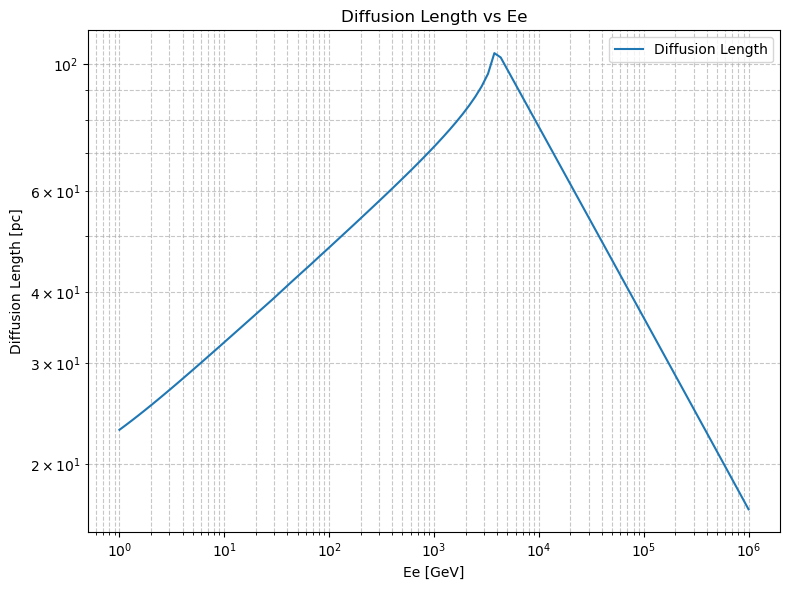

In [53]:
# Define parameters for the plot
E0 = 1e6  # Initial energy in GeV (example value)
r = 0     # Distance in parsecs (example value)

# Generate a range of Ee values
Ee_values = np.logspace(0, 6, 100)  # From 1 GeV to 1e6 GeV
diffusion_lengths = []

# time for monogem
tage = (370e3)*conv_yr_sec # tobs in seconds


# Compute diffusion lengths for each Ee
for Ee in Ee_values:
    try:
        E0 = E0_val(Ee, tage)
        diffusion_lengths.append(diffusion_len(E0, Ee, r)*conv_cm_pc)
    except Exception as e:
        print(f"Error for Ee={Ee}: {e}")
        diffusion_lengths.append(np.nan)

# Plot the diffusion length
plt.figure(figsize=(8, 6))
plt.loglog(Ee_values, diffusion_lengths, label="Diffusion Length")
plt.xlabel("Ee [GeV]")
plt.ylabel("Diffusion Length [pc]")
plt.title("Diffusion Length vs Ee")
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Single Zone Diffusion Test

In [ ]:
def H_one_zone(Ee, t, r = 0):
    '''
    One zone model found in Mauro et al. and various other papers. 
    This is what hooper uses.
    '''

    E0 = E0_val(Ee, tage)
    dl = diffusion_len(E0, Ee, r)

    term1 = 1/(np.pi**(3/2) * dl**3)
    term2 = np.exp(-(r**2)/(dl**2))

    result = term1*term2

    return result


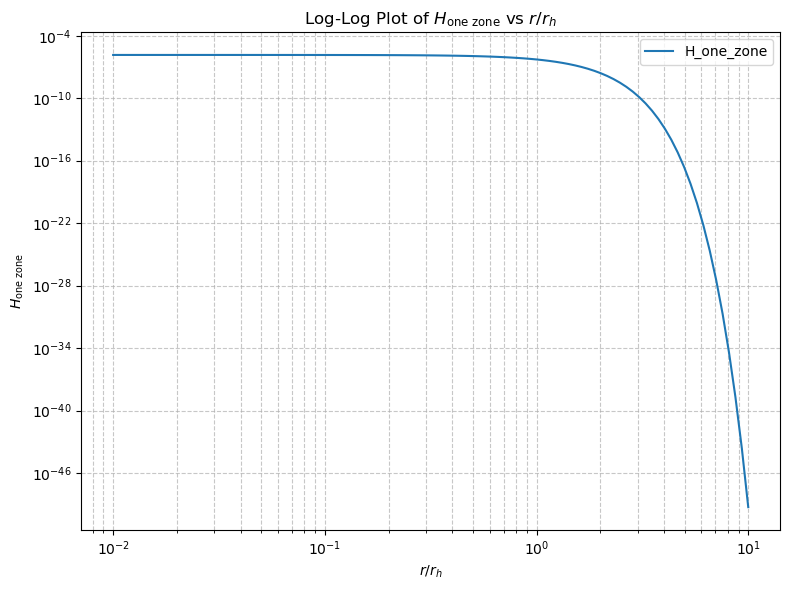

In [61]:
# Define parameters
rh = 50  # Transition radius in parsecs
Ee = 1e3  # Example electron energy in GeV
t = 1e6 * conv_yr_sec  # Example time in seconds (1 Myr)

# Generate a range of r/rh values
r_over_rh = np.logspace(-2, 1, 100)  # From 0.01 to 10 times rh
r_values = r_over_rh * rh  # Convert to actual r values

# Compute H_one_zone for each r
H_values = [H_one_zone(Ee, t, r) for r in r_values]

# Plot H_one_zone vs r/rh on a log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(r_over_rh, H_values, label="H_one_zone")
plt.xlabel(r"$r/r_h$")
plt.ylabel(r"$H_{\mathrm{one\ zone}}$")
plt.title(r"Log-Log Plot of $H_{\mathrm{one\ zone}}$ vs $r/r_h$")
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Di Mauro -->  H Result

In [54]:

def H(r, Ee, E0, rs = 1):
    '''
    Defined in Di Mauro et. al. paper
    
    - perams - 
    r: position in galactic coordinates
    '''

    # rs is the source position
    del_r = r - rs

    # diffusion lengths
    l_0 = diffusion_len(Ee, E0, 0)*conv_cm_pc # setting r to 0 pc so it uses D0
    l_ism = diffusion_len(Ee, E0, 100)*conv_cm_pc # setting r to 100 pc so it uses Dism

    # Defining perameters in paper
    D0 = 1e26 # cm^2 / s
    Dism = 4e28 # cm^2 / s

    # rh: radius when the diffusion model 'switches zones, set as 30 pc in hooper
    rh = 30 # parsecs

    xi = np.sqrt(D0/Dism)

    # epsilon definition
    ep = rh/l_0
    erf = sp.special.erf(ep)
    erfc = sp.special.erfc(ep)

    # Implementing the function
    bot00 = (np.pi*(l_0**2))**(3/2)
    bot01 = 2*(xi**2)*erf
    bot02 = xi*(xi-1)*erf
    bot03 = 2*erfc
    term0 = (xi*(xi+1)) / (bot00)*(bot01 - bot02 + bot03) 

    # r dependence
    if r < rh:
        term1 = np.exp( - (del_r**2) / (l_0**2) )
        term21 = (xi-1)/(xi + 1)
        term22 = (2*rh)/(r) - 1
        term23 = np.exp( - ((del_r-2*rh)**2) / (l_0**2) )
        term2 = term21*term22*term23

        result = term0*(term1+term2)

    else:
        term01 = (2*xi)/(xi + 1)
        term02 = np.exp( - (((del_r - rh)/l_ism) + rh/l_0 )**2 )
        term1 = rh/r
        term2 = xi*(1-rh/r)

        result = term0*term01*term02*(term1 + term2)

    return result

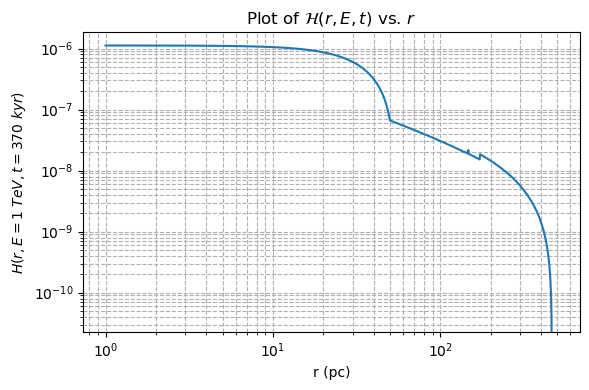

In [70]:
params = Params()
params.D0 = params.D0   # e.g., diffusion constant inside region (cm^2/s or chosen units)
params.D1 = params.Dism # diffusion constant outside region

r0 = 50.0         # parsecs



def H(r, E, t):
    """
    Compute H(r,E,t) by numerically integrating over psi from 0 to infinity.
    Uses piecewise form depending on r < r0 or r >= r0.
    """
    lam = 50 # pc
    # lam = diffusion_len(E, t, 0)
    
    # xi = np.sqrt(params.D0 / params.D1)
    xi = np.sqrt(1/100)
    
    def integrand(psi):
        # Avoid division by zero at psi=0
        if psi == 0:
            return 0.0
        chi = 2.0 * np.sqrt(psi) * r0 / lam
        # Compute A(psi) according to given formula
        A = (xi * np.cos(chi) * np.cos(xi * chi) +
             np.sin(chi) * np.sin(xi * chi) +
             (1.0 - xi) / chi * np.sin(chi) * np.cos(xi * chi))
        # Compute B(psi) as given
        B = (np.sin(chi) - A * np.sin(xi * chi)) / np.cos(xi * chi)
        # Prefactor common to both cases
        prefac = xi * np.exp(-psi) / (np.pi**2 * lam**2 * (A**2 + B**2))
        if r < r0:
            return prefac * (1.0/r) * np.sin(2.0 * np.sqrt(psi) * r / lam)
        else:
            return (prefac * (1.0/r) *
                    (A * np.sin(2.0 * np.sqrt(psi) * r * xi / lam) +
                     B * np.cos(2.0 * np.sqrt(psi) * r * xi / lam)))
    
    # Perform the integration from 0 to +inf (approximated by a finite upper limit or quad's inf handling)
    value, error = quad(integrand, 0, np.inf, limit = 100)
    return value

# Parameters for evaluation
E = 1e3     # 
t = 370e3    # in years (370 kyr)

# Sample r from 1 to 1000 pc on a log scale
r_values = np.logspace(0, 2.7, 1000)
H_values = [H(r, E, t) for r in r_values]

# Plot H(r) vs r
plt.figure(figsize=(6,4))
plt.loglog(r_values, H_values)
plt.xlabel('r (pc)')
plt.ylabel(r'$H(r, E=1\ TeV, t=370\ kyr)$')
plt.title(r'Plot of $\mathcal{H}(r,E,t)$ vs. $r$')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()
